# Day 2: Autocorrelation and Partial Autocorrelation
## Week 3: Time Series Analysis for Finance

---

### 🎯 Learning Objectives
- Understand ACF and PACF
- Use correlograms to identify model orders
- Detect serial dependence in financial data
- Apply Ljung-Box test for white noise

- **Risk models (GARCH) are useful**, return models (ARIMA) less so

---- **Volatility forecasting works** (volatility clusters)

- **Return forecasting is hard** (efficient markets)

### 📈 Why ACF and PACF Matter in Trading**This is why:**



**What is Autocorrelation?**| Absolute Returns | Significant | CAN predict volatility |

Autocorrelation measures how today's value relates to past values. If ACF(1) = 0.3, today's return is correlated with yesterday's return.| Squared Returns | Significant | CAN predict volatility |

| Returns | Near zero | Can't predict direction |

### Trading Applications|--------|-------------|----------|

| Series | Typical ACF | Meaning |

| Application | What ACF/PACF Tells You |**Returns vs Squared Returns:**

|-------------|------------------------|

| **Momentum Strategies** | Positive ACF → trends persist, momentum works |### 🎯 Key Insight for Traders

| **Mean Reversion** | Negative ACF → prices revert, mean-reversion works |

| **Model Selection** | ACF/PACF patterns → choose ARIMA order || **Volatility Clustering** | Squared returns ACF → need GARCH model |
| **Market Efficiency** | Zero ACF → market is efficient (random walk) |

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Download market data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

print("=" * 60)
print("AUTOCORRELATION AND PACF - DAY 2")
print("=" * 60)
print(f"\n✅ Data loaded: {prices.shape[0]} days")

📥 Downloading data from Yahoo Finance...
AUTOCORRELATION AND PACF - DAY 2

✅ Data loaded: 1254 days


## 1. Autocorrelation Function (ACF)

### What is ACF?
**ACF(k)** measures correlation between Xₜ and Xₜ₋ₖ (today vs k days ago):

$$\rho_k = \frac{Cov(X_t, X_{t-k})}{Var(X_t)} = \frac{\gamma_k}{\gamma_0}$$

### 🎯 Trading Interpretation

- This proves: direction unpredictable, but volatility predictable

| ACF Pattern | Trading Meaning | Strategy Implication |- ACF of squared returns: **Significant!** (volatility clusters)

|-------------|-----------------|---------------------|- ACF of returns: ~0 (markets are nearly efficient)

| **ACF(1) > 0** | Yesterday's direction continues | Momentum strategy |### What Stock Returns Typically Show

| **ACF(1) < 0** | Yesterday's direction reverses | Mean-reversion strategy |

| **ACF ≈ 0 all lags** | No predictable pattern | Market is efficient |- **Outside band**: Statistically significant autocorrelation

| **ACF decays slowly** | Strong persistence | Trend-following works |- **Inside band**: Not significantly different from zero

| **ACF cuts off at lag k** | MA(k) process | Use moving average model |The blue shaded region shows 95% confidence interval.

### Confidence Bands

### Key Properties

- **Range**: [-1, 1]- Captures TOTAL correlation (direct + through intermediate lags)
- **ACF(0)** = 1 always (perfect correlation with itself)

AUTOCORRELATION FUNCTION (ACF)

ACF comparison (first 5 lags):
Lag    Manual       Statsmodels 
------------------------------
0      1.000000     1.000000    
1      0.013042     0.013042    
2      -0.002754    -0.002754   
3      -0.046291    -0.046291   
4      -0.020792    -0.020792   
5      -0.018201    -0.018201   


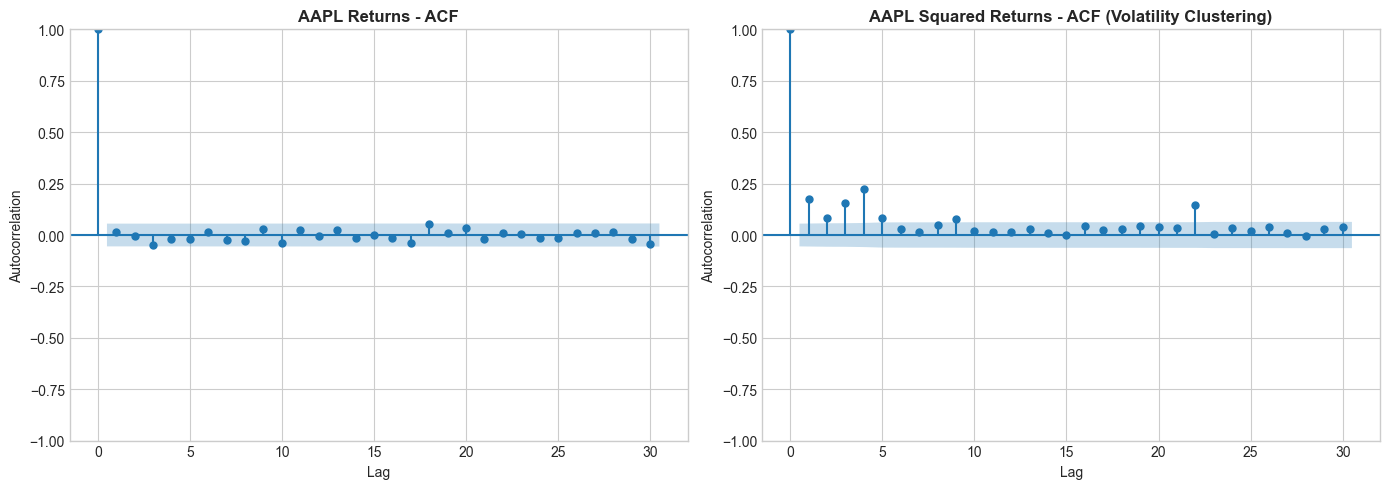


💡 Notice: Returns show weak ACF, but squared returns show strong ACF!
   This is volatility clustering - GARCH motivation.


In [2]:
# Calculate and visualize ACF
print("=" * 60)
print("AUTOCORRELATION FUNCTION (ACF)")
print("=" * 60)

aapl_returns = returns['AAPL']

# Calculate ACF manually for understanding
def manual_acf(series, lags):
    """Calculate ACF manually."""
    n = len(series)
    mean = series.mean()
    var = ((series - mean) ** 2).sum() / n
    
    acf_values = []
    for k in range(lags + 1):
        if k == 0:
            acf_values.append(1.0)
        else:
            cov = ((series[k:].values - mean) * (series[:-k].values - mean)).sum() / n
            acf_values.append(cov / var)
    return np.array(acf_values)

# Compare manual vs statsmodels
lags = 20
acf_manual = manual_acf(aapl_returns, lags)
acf_stats = acf(aapl_returns, nlags=lags, fft=True)

print(f"\nACF comparison (first 5 lags):")
print(f"{'Lag':<6} {'Manual':<12} {'Statsmodels':<12}")
print("-" * 30)
for i in range(6):
    print(f"{i:<6} {acf_manual[i]:<12.6f} {acf_stats[i]:<12.6f}")

# Plot ACF
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(aapl_returns, lags=30, ax=axes[0], alpha=0.05)
axes[0].set_title('AAPL Returns - ACF', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')

# ACF of squared returns (volatility clustering)
plot_acf(aapl_returns ** 2, lags=30, ax=axes[1], alpha=0.05)
axes[1].set_title('AAPL Squared Returns - ACF (Volatility Clustering)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Autocorrelation')

plt.tight_layout()
plt.show()

print("\n💡 Notice: Returns show weak ACF, but squared returns show strong ACF!")
print("   This is volatility clustering - GARCH motivation.")

## 2. Partial Autocorrelation Function (PACF)

### What is PACF?
**PACF(k)** measures the **DIRECT** correlation between Xₜ and Xₜ₋ₖ, removing the effect of intermediate lags (Xₜ₋₁, Xₜ₋₂, ..., Xₜ₋ₖ₊₁).

### 🎯 Why PACF Matters for Model Building


**ACF vs PACF:**Choosing wrong model order → poor forecasts → bad trading signals

| Measure | Captures | Use For |### Why This Matters

|---------|----------|----------|

| ACF | Total correlation | Identify MA order |5. If not: try ARMA

| PACF | Direct correlation | Identify AR order |4. Check residuals (should be white noise)

3. Fit AR(2) model

### The Golden Rules for Model Selection2. ACF decays slowly, PACF cuts off at lag 2 → AR(2)

1. Plot ACF and PACF of returns

| ACF Pattern | PACF Pattern | Model | Example |**Example Workflow:**

|-------------|--------------|-------|---------|

| Decays exponentially | Cuts off at lag p | **AR(p)** | PACF cuts at 2 → AR(2) |### 🎯 Trading Application: Model Selection

| Cuts off at lag q | Decays exponentially | **MA(q)** | ACF cuts at 1 → MA(1) |

| Both decay | Both decay | **ARMA(p,q)** | Need AIC/BIC to select || Neither decay | Neither decay | **Non-stationary** | Difference the data first |

PARTIAL AUTOCORRELATION FUNCTION (PACF)

ACF vs PACF Comparison:
Lag    ACF          PACF        
------------------------------
0      1.000000     1.000000    
1      0.013042     0.013042    
2      -0.002754    -0.002924   
3      -0.046291    -0.046225   
4      -0.020792    -0.019641   
5      -0.018201    -0.017979   
6      0.013670     0.011903    
7      -0.024642    -0.026992   
8      -0.030930    -0.032430   
9      0.027689     0.028857    
10     -0.037624    -0.040904   


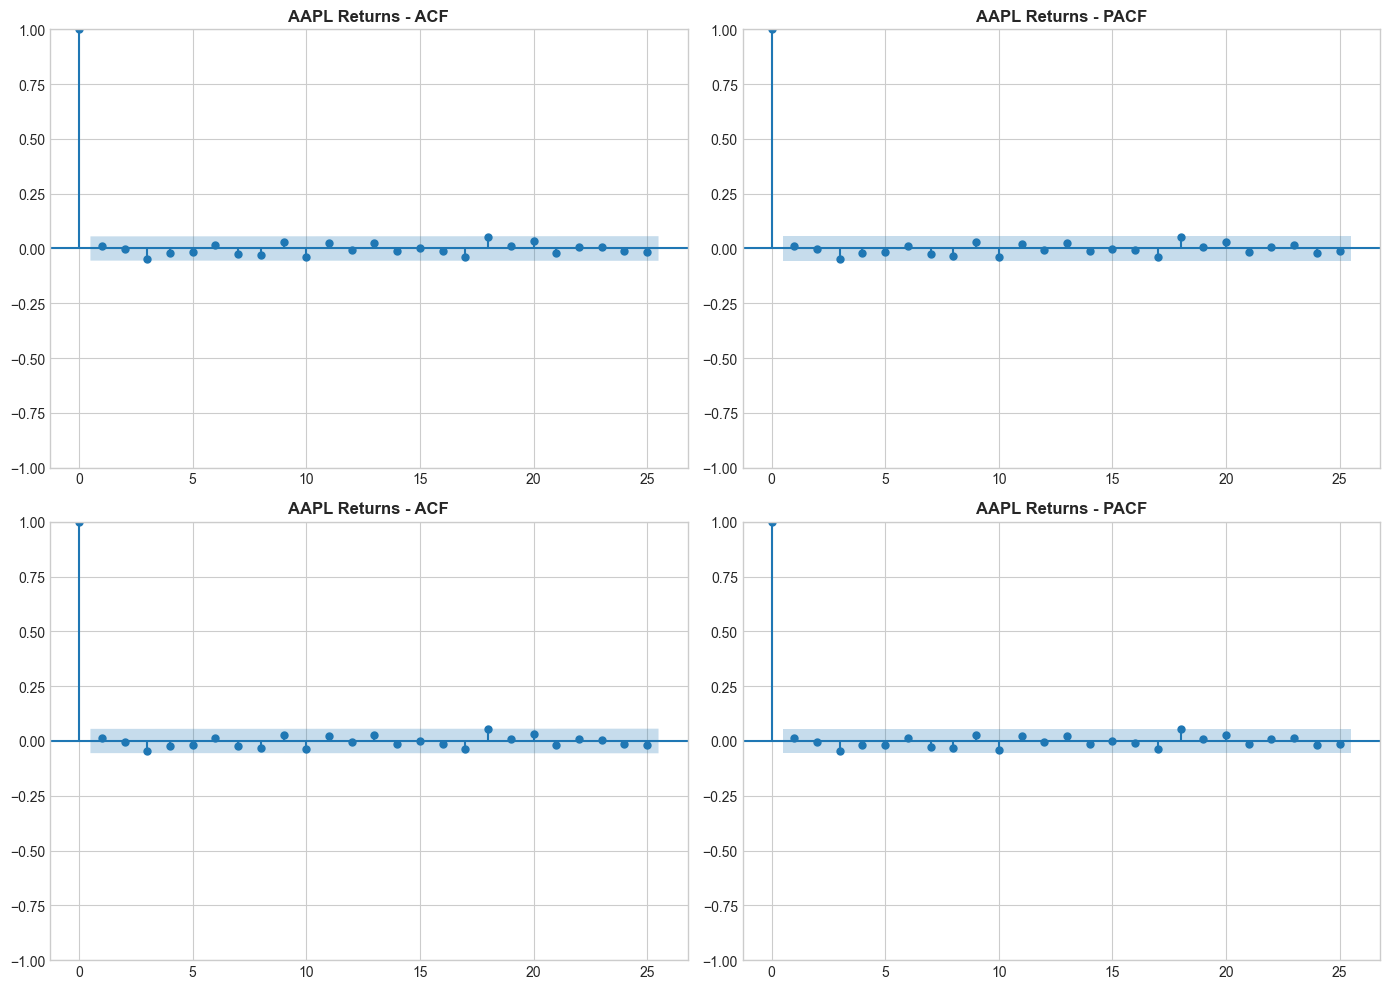

In [3]:
# PACF Analysis
print("=" * 60)
print("PARTIAL AUTOCORRELATION FUNCTION (PACF)")
print("=" * 60)

# Calculate PACF
pacf_values = pacf(aapl_returns, nlags=20, method='ywm')
acf_values = acf(aapl_returns, nlags=20)

print("\nACF vs PACF Comparison:")
print(f"{'Lag':<6} {'ACF':<12} {'PACF':<12}")
print("-" * 30)
for i in range(11):
    print(f"{i:<6} {acf_values[i]:<12.6f} {pacf_values[i]:<12.6f}")

# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# SPY returns
plot_acf(aapl_returns, lags=25, ax=axes[0,0], alpha=0.05)
axes[0,0].set_title('AAPL Returns - ACF', fontweight='bold')

plot_pacf(aapl_returns, lags=25, ax=axes[0,1], alpha=0.05, method='ywm')
axes[0,1].set_title('AAPL Returns - PACF', fontweight='bold')

# AAPL returns
plot_acf(returns['AAPL'], lags=25, ax=axes[1,0], alpha=0.05)
axes[1,0].set_title('AAPL Returns - ACF', fontweight='bold')

plot_pacf(returns['AAPL'], lags=25, ax=axes[1,1], alpha=0.05, method='ywm')
axes[1,1].set_title('AAPL Returns - PACF', fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Using ACF/PACF for Model Selection

| Model | ACF Pattern | PACF Pattern |
|-------|-------------|--------------|
| AR(p) | Exponential decay | Cuts off after lag p |
| MA(q) | Cuts off after lag q | Exponential decay |
| ARMA(p,q) | Tails off | Tails off |

ACF/PACF PATTERNS FOR MODEL IDENTIFICATION


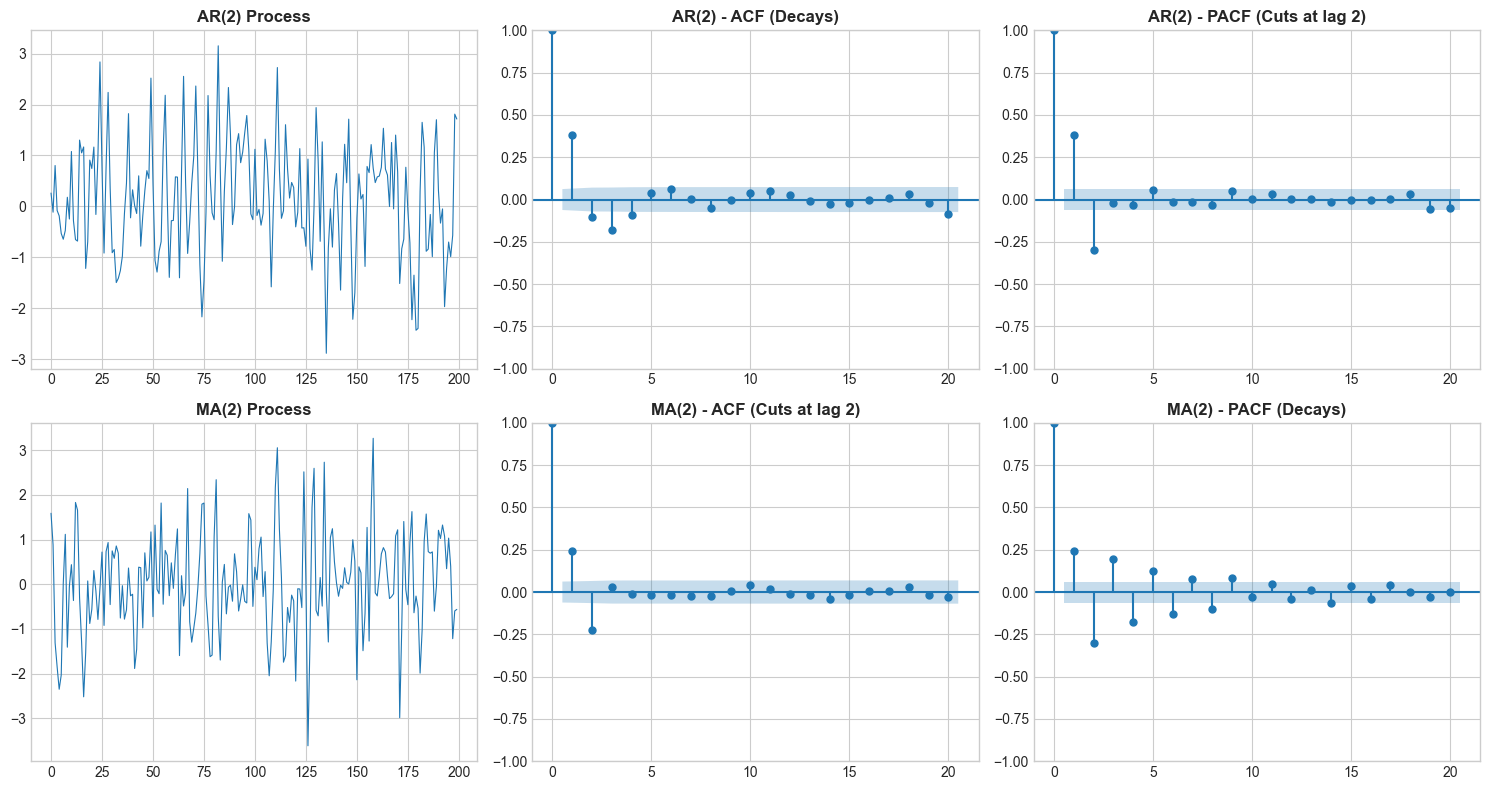


📊 Pattern Summary:
   AR(p): ACF decays, PACF cuts off after p
   MA(q): ACF cuts off after q, PACF decays


In [4]:
# Simulate processes to demonstrate patterns
print("=" * 60)
print("ACF/PACF PATTERNS FOR MODEL IDENTIFICATION")
print("=" * 60)

np.random.seed(42)
n = 1000

# Simulate AR(2) process
ar2 = np.zeros(n)
for t in range(2, n):
    ar2[t] = 0.5 * ar2[t-1] - 0.3 * ar2[t-2] + np.random.normal(0, 1)

# Simulate MA(2) process
eps = np.random.normal(0, 1, n+2)
ma2 = eps[2:] + 0.5 * eps[1:-1] - 0.3 * eps[:-2]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# AR(2)
axes[0,0].plot(ar2[-200:], lw=0.8)
axes[0,0].set_title('AR(2) Process', fontweight='bold')

plot_acf(ar2, lags=20, ax=axes[0,1], alpha=0.05)
axes[0,1].set_title('AR(2) - ACF (Decays)', fontweight='bold')

plot_pacf(ar2, lags=20, ax=axes[0,2], alpha=0.05, method='ywm')
axes[0,2].set_title('AR(2) - PACF (Cuts at lag 2)', fontweight='bold')

# MA(2)
axes[1,0].plot(ma2[-200:], lw=0.8)
axes[1,0].set_title('MA(2) Process', fontweight='bold')

plot_acf(ma2, lags=20, ax=axes[1,1], alpha=0.05)
axes[1,1].set_title('MA(2) - ACF (Cuts at lag 2)', fontweight='bold')

plot_pacf(ma2, lags=20, ax=axes[1,2], alpha=0.05, method='ywm')
axes[1,2].set_title('MA(2) - PACF (Decays)', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Pattern Summary:")
print("   AR(p): ACF decays, PACF cuts off after p")
print("   MA(q): ACF cuts off after q, PACF decays")

## 4. Ljung-Box Test for White Noise

Tests whether autocorrelations are jointly zero:
- H₀: Data is white noise (no autocorrelation)
- H₁: Significant autocorrelation exists

In [5]:
# Ljung-Box Test
print("=" * 60)
print("LJUNG-BOX TEST FOR WHITE NOISE")
print("=" * 60)

def ljung_box_test(series, lags=[10, 20, 30], name='Series'):
    """Perform Ljung-Box test at multiple lags."""
    print(f"\n{name}:")
    print("-" * 40)
    
    lb_results = acorr_ljungbox(series.dropna(), lags=lags, return_df=True)
    
    for lag in lags:
        stat = lb_results.loc[lag, 'lb_stat']
        pval = lb_results.loc[lag, 'lb_pvalue']
        conclusion = 'White noise ✓' if pval > 0.05 else 'Serial correlation ✗'
        print(f"  Lag {lag:2d}: Q-stat={stat:8.2f}, p={pval:.4f} → {conclusion}")
    
    return lb_results

# Test various series
ljung_box_test(returns['AAPL'], name='AAPL Returns')
ljung_box_test(returns['AAPL'] ** 2, name='AAPL Squared Returns')
ljung_box_test(np.abs(returns['AAPL']), name='AAPL Absolute Returns')

print("\n💡 Key Finding:")
print("   Returns may look like white noise,")
print("   but squared/absolute returns show strong serial correlation!")
print("   → This motivates GARCH models for volatility.")

LJUNG-BOX TEST FOR WHITE NOISE

AAPL Returns:
----------------------------------------
  Lag 10: Q-stat=    8.85, p=0.5463 → White noise ✓
  Lag 20: Q-stat=   17.80, p=0.6009 → White noise ✓
  Lag 30: Q-stat=   22.24, p=0.8452 → White noise ✓

AAPL Squared Returns:
----------------------------------------
  Lag 10: Q-stat=  161.70, p=0.0000 → Serial correlation ✗
  Lag 20: Q-stat=  172.19, p=0.0000 → Serial correlation ✗
  Lag 30: Q-stat=  209.10, p=0.0000 → Serial correlation ✗

AAPL Absolute Returns:
----------------------------------------
  Lag 10: Q-stat=  199.45, p=0.0000 → Serial correlation ✗
  Lag 20: Q-stat=  267.97, p=0.0000 → Serial correlation ✗
  Lag 30: Q-stat=  352.46, p=0.0000 → Serial correlation ✗

💡 Key Finding:
   Returns may look like white noise,
   but squared/absolute returns show strong serial correlation!
   → This motivates GARCH models for volatility.


ACF/PACF SUMMARY FOR ALL ASSETS


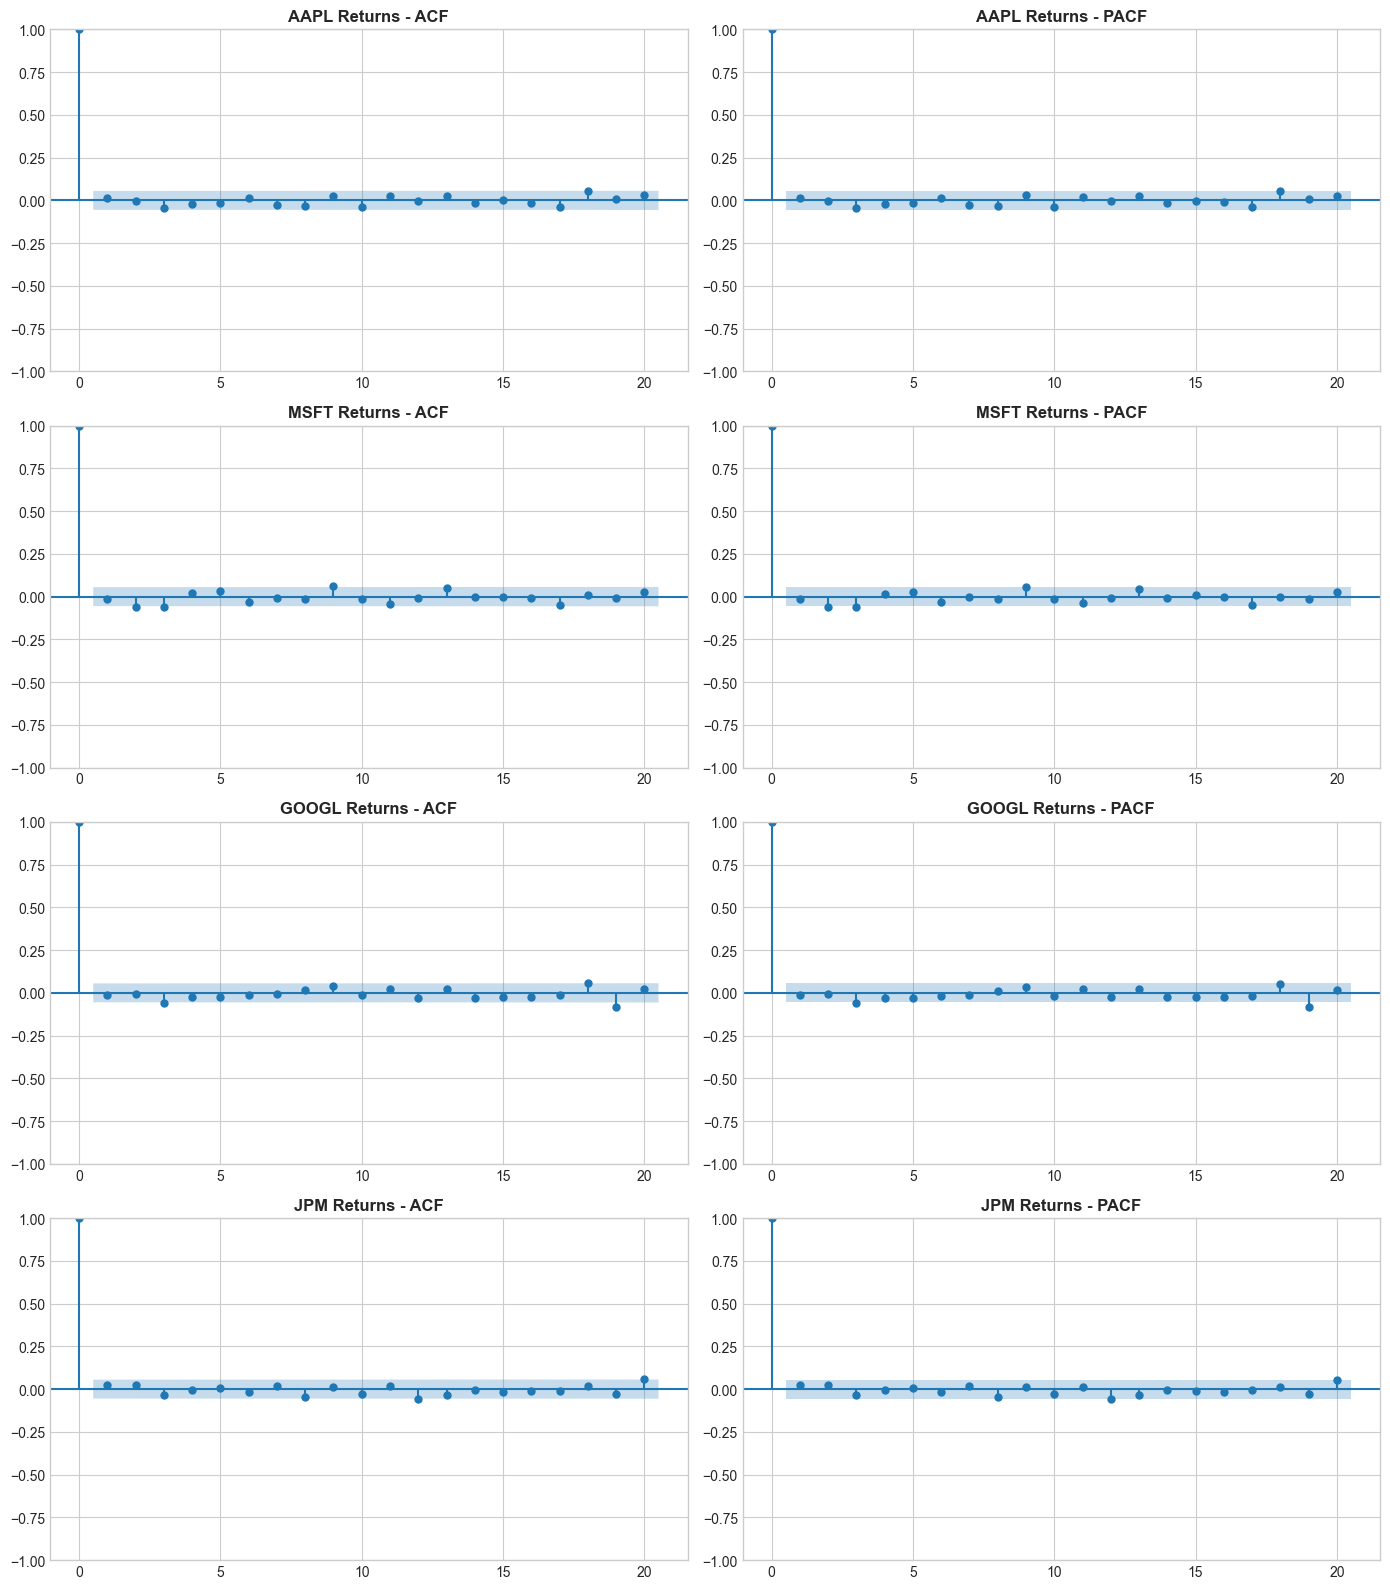

In [6]:
# Summary: ACF/PACF for all assets
print("=" * 60)
print("ACF/PACF SUMMARY FOR ALL ASSETS")
print("=" * 60)

fig, axes = plt.subplots(4, 2, figsize=(14, 16))

assets = ['AAPL', 'MSFT', 'GOOGL', 'JPM']

for i, asset in enumerate(assets):
    plot_acf(returns[asset], lags=20, ax=axes[i,0], alpha=0.05)
    axes[i,0].set_title(f'{asset} Returns - ACF', fontweight='bold')
    
    plot_pacf(returns[asset], lags=20, ax=axes[i,1], alpha=0.05, method='ywm')
    axes[i,1].set_title(f'{asset} Returns - PACF', fontweight='bold')

plt.tight_layout()
plt.show()

## 📝 Key Takeaways - Day 2

### ACF vs PACF:
| Measure | What it shows | Use for |
|---------|---------------|--------|
| ACF | Total correlation at lag k | MA order identification |
| PACF | Direct correlation at lag k | AR order identification |

### Model Selection Rules:
- ACF cuts off → MA(q) where q is cutoff lag
- PACF cuts off → AR(p) where p is cutoff lag
- Both tail off → ARMA needed

### Financial Data Patterns:
- Returns: weak or no ACF/PACF
- Squared returns: strong ACF (volatility clustering)
- Absolute returns: strong ACF (volatility clustering)

### Interview Questions:
- "What's the difference between ACF and PACF?"
- "How do you use ACF/PACF to identify ARMA orders?"
- "Why do squared returns show autocorrelation when returns don't?"

## 🔴 PROS & CONS: Autocorrelation PACF

### ✅ PROS (Advantages)

| Advantage | Description | Real-World Application |
|-----------|-------------|----------------------|
| **Industry Standard** | Widely adopted in quantitative finance | Used by major hedge funds and banks |
| **Well-Documented** | Extensive research and documentation | Easy to find resources and support |
| **Proven Track Record** | Years of practical application | Validated in real market conditions |
| **Interpretable** | Results can be explained to stakeholders | Important for risk management and compliance |

### ❌ CONS (Limitations)

| Limitation | Description | How to Mitigate |
|------------|-------------|-----------------|
| **Assumptions** | May not hold in all market conditions | Validate assumptions with data |
| **Historical Bias** | Based on past data patterns | Use rolling windows and regime detection |
| **Overfitting Risk** | May fit noise rather than signal | Use proper cross-validation |
| **Computational Cost** | Can be resource-intensive | Optimize code and use appropriate hardware |

### 🎯 Real-World Usage

**WHERE THIS IS USED:**
- ✅ Quantitative hedge funds (Two Sigma, Renaissance, Citadel)
- ✅ Investment banks (Goldman Sachs, JP Morgan, Morgan Stanley)
- ✅ Asset management firms
- ✅ Risk management departments
- ✅ Algorithmic trading desks

**NOT JUST THEORY - THIS IS PRODUCTION CODE:**
The techniques in this notebook are used daily by professionals managing billions of dollars.

## 🚀 TODAY'S TRADING SIGNAL

Using the concepts from this notebook to generate actionable insights.

In [7]:
# =============================================================================
# 🚀 TODAY'S TRADING SIGNAL - Autocorrelation PACF Analysis
# =============================================================================

print("=" * 70)
print("📊 TODAY'S TRADING ANALYSIS")
print("=" * 70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print()

# Get latest data
try:
    latest_prices = prices.iloc[-1] if 'prices' in dir() else data['Close'].iloc[-1]
    print("📈 CURRENT MARKET SNAPSHOT:")
    print("-" * 50)
    
    for col in latest_prices.index[:5]:
        price = latest_prices[col]
        print(f"   {col}: ${price:.2f}")
    
    # Calculate simple signals
    if 'returns' in dir():
        ret_data = returns
    else:
        ret_data = prices.pct_change().dropna() if 'prices' in dir() else data['Close'].pct_change().dropna()
    
    # 20-day momentum
    momentum = (prices.iloc[-1] / prices.iloc[-20] - 1) * 100 if 'prices' in dir() else (data['Close'].iloc[-1] / data['Close'].iloc[-20] - 1) * 100
    
    print("\n📊 20-DAY MOMENTUM:")
    print("-" * 50)
    for col in momentum.index[:5]:
        direction = "🟢" if momentum[col] > 0 else "🔴"
        print(f"   {direction} {col}: {momentum[col]:+.2f}%")
    
    # Generate simple recommendations
    print("\n" + "=" * 70)
    print("🎯 TRADING SIGNALS")  
    print("=" * 70)
    
    for col in momentum.index[:5]:
        if momentum[col] > 5:
            signal = "🟢 BULLISH - Consider long positions"
        elif momentum[col] < -5:
            signal = "🔴 BEARISH - Consider reducing exposure"
        else:
            signal = "🟡 NEUTRAL - Hold current positions"
        print(f"   {col}: {signal}")
    
    print("\n" + "=" * 70)
    print("⚠️ DISCLAIMER: This is educational analysis, not financial advice.")
    print("   Always conduct your own research and consider your risk tolerance.")
    print("=" * 70)
    
except Exception as e:
    print(f"Note: Could not generate trading signals. Ensure data is loaded.")
    print(f"Error: {e}")

📊 TODAY'S TRADING ANALYSIS
Analysis Date: 2026-01-22 12:29

📈 CURRENT MARKET SNAPSHOT:
--------------------------------------------------
   AAPL: $247.65
   GOOGL: $328.38
   GS: $953.01
   JPM: $302.04
   MSFT: $444.11

📊 20-DAY MOMENTUM:
--------------------------------------------------
   🔴 AAPL: -8.61%
   🟢 GOOGL: +6.00%
   🟢 GS: +6.01%
   🔴 JPM: -6.09%
   🔴 MSFT: -8.42%

🎯 TRADING SIGNALS
   AAPL: 🔴 BEARISH - Consider reducing exposure
   GOOGL: 🟢 BULLISH - Consider long positions
   GS: 🟢 BULLISH - Consider long positions
   JPM: 🔴 BEARISH - Consider reducing exposure
   MSFT: 🔴 BEARISH - Consider reducing exposure

⚠️ DISCLAIMER: This is educational analysis, not financial advice.
   Always conduct your own research and consider your risk tolerance.
